# Test Model Architecture

## Run on an AWS g5.xlarge demand / g5.24xlarge spot

In [1]:
import os
import io
import sys
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from datetime import datetime

2025-01-01 18:33:08.548841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 18:33:08.565021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 18:33:08.570097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 18:33:08.582327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f"Tensorflow version {tf.__version__}")
print("Python version:",    sys.version.split(" ")[0])
print("NumPy version:",   np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-Learn version:", sklearn.__version__)

Tensorflow version 2.17.0
Python version: 3.11.11
NumPy version: 1.26.4
Pandas version: 2.2.3
Scikit-Learn version: 1.5.2


In [3]:
import os
import multiprocessing
import tensorflow as tf

# Using os module
num_cores_os = os.cpu_count()
print(f"\nNumber of cores (os.cpu_count): {num_cores_os}\n")

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print(f"\nNumber of GPUs available: {len(gpus)}")

for gpu in gpus:
    print(f"GPU: {gpu}")


Number of cores (os.cpu_count): 4


Number of GPUs available: 1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1735781592.162546   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735781592.208602   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735781592.210787   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
import os
import random

random_state=17

random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)
tf.keras.utils.set_random_seed(random_state)
os.environ['PYTHONHASHSEED'] = str(random_state)

# Clear out all the folder structures

In [5]:
def clear_files_keep_folders(root_dir):
   """Delete all files in directory tree but keep the folder structure."""
   for dirpath, dirnames, filenames in os.walk(root_dir):
       for filename in filenames:
           file_path = os.path.join(dirpath, filename)
           try:
               os.remove(file_path)
               print(f"Deleted: {file_path}")
           except Exception as e:
               print(f"Error deleting {file_path}: {e}")

root_dirs = ["model_checkpoints", 'model_statistics']

for root_dir in root_dirs:
    os.makedirs(root_dir, exist_ok=True)
    clear_files_keep_folders(root_dir)

Deleted: model_statistics/training_history.csv


# Set system clock

In [6]:
!sudo timedatectl set-timezone US/Mountain

# Load global variables

In [7]:
import pickle


with open('saved_variables/data_files.pkl', 'rb') as f:
    data_files = pickle.load(f)

for key, value in data_files.items():
    if key.startswith('df_'):
        # For dataframes, print head(2) instead of full frame
        print(f"\n{key}:")
        print(f"{value.shape})")
        display(value.head(2))
    elif key == 'y_true' and isinstance(value, (list, tuple, np.ndarray)):
        # If 'y_true' is found, display its shape
        print(f"\n{key:<25} shape = {value.shape}")
    else:
        # For other variables, print normally
        print(f"{key:<25} = {value}")

for key, value in data_files.items():
    globals()[key] = value

target_w                  = 320
target_h                  = 320
input_shape               = (320, 320, 3)
target_size               = (320, 320)
dataset_size              = 112120
local_image_directory     = nih_xrays_320
num_labels                = 14
label_text                = ['Infiltration', 'Effusion', 'Atelectasis', 'Nodule', 'Mass', 'Pneumothorax', 'Consolidation', 'Pleural_Thickening', 'Cardiomegaly', 'Emphysema', 'Edema', 'Fibrosis', 'Pneumonia', 'Hernia']
y_pred_threshold_gt       = 0.5

df_train:
(101136, 16))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
0,00001249_010.png,1249,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,00029173_000.png,29173,0,0,0,0,0,0,0,0,0,0,0,0,0,0



df_val:
(5429, 16))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
1,00018521_004.png,18521,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72,00016429_012.png,16429,0,0,0,0,0,1,0,0,0,0,0,0,0,0



df_test:
(5555, 16))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
15,00020057_000.png,20057,0,0,0,0,0,0,0,0,0,1,0,0,0,0
40,00025085_018.png,25085,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Sample an image before preprocessing


Image Analysis for: nih_xrays_320/00016841_010.png
--------------------------------------------------
File path: nih_xrays_320/00016841_010.png
File size: 43.11 KB

PIL Image Info:
Format: PNG
Mode: L
Size (width x height): (320, 320)
Color palette: No

NumPy Array Info:
Shape: (320, 320)
Data type: uint8
Number of dimensions: 2
Number of channels: 1
Min value: 0
Max value: 246
Mean value: 122.03


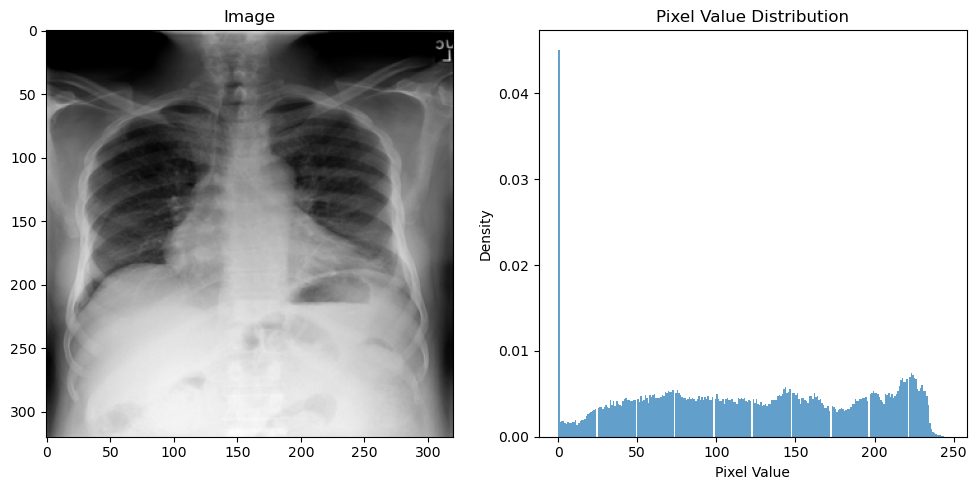

In [8]:
from PIL import Image as PIL_Image
import matplotlib.pyplot as plt

def analyze_random_image(directory):
    # Get list of all PNG files
    png_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                png_files.append(os.path.join(root, file))
    
    if not png_files:
        print("No PNG files found in directory!")
        return
    
    # Select random image
    random_image_path = random.choice(png_files)
    # random_image_path_for_post_preprocessing = random_image_path
    
    # Open with PIL
    img_pil = PIL_Image.open(random_image_path)
    
    # Convert to numpy array
    img_array = np.array(img_pil)
    # img_array = tf.image.grayscale_to_rgb(img_array)
    
    # Gather metadata
    print(f"\nImage Analysis for: {directory}/{os.path.basename(random_image_path)}")
    print("-" * 50)
    print(f"File path: {random_image_path}")
    print(f"File size: {os.path.getsize(random_image_path) / 1024:.2f} KB")
    print("\nPIL Image Info:")
    print(f"Format: {img_pil.format}")
    print(f"Mode: {img_pil.mode}")
    print(f"Size (width x height): {img_pil.size}")
    print(f"Color palette: {'Yes' if img_pil.palette else 'No'}")
    
    print("\nNumPy Array Info:")
    print(f"Shape: {img_array.shape}")
    print(f"Data type: {img_array.dtype}")
    print(f"Number of dimensions: {img_array.ndim}")
    print(f"Number of channels: {img_array.shape[-1] if img_array.ndim > 2 else 1}")
    print(f"Min value: {img_array.min()}")
    print(f"Max value: {img_array.max()}")
    print(f"Mean value: {img_array.mean():.2f}")
    
    # Display the image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray' if img_array.ndim == 2 else None)
    plt.title("Image")
    plt.axis('on')
    
    plt.subplot(1, 2, 2)
    plt.hist(img_array.ravel(), bins=256, density=True, alpha=0.7)
    plt.title("Pixel Value Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    # return img_array, img_pil

# Run the analysis
analyze_random_image(directory=local_image_directory)

# Weighted Loss Functions

In [9]:
import tensorflow as tf


class DynamicWeightedBCE(tf.keras.losses.Loss):
   """
   Dynamic weighting based on batch statistics. Adapts weights during training.
   
   Example:
       # For dataset with varying class distributions
       loss_fn = DynamicWeightedBCE()
       model.compile(optimizer='adam', loss=loss_fn)
   """
   def call(self, y_true, y_pred):
       epsilon = tf.keras.backend.epsilon()
       y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
       
       # Calculate class ratios per batch
       pos_ratio = tf.reduce_mean(y_true, axis=0)
       pos_weights = 1.0 / (pos_ratio + epsilon)
       neg_weights = 1.0 / (1.0 - pos_ratio + epsilon)
       
       return -tf.reduce_mean(
           y_true * pos_weights * tf.math.log(y_pred) +
           (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
       )

class DynamicWeightedBCE_temp(tf.keras.losses.Loss):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Temperature scaling for smoother gradients
        y_pred = y_pred ** (1/self.temperature)
        
        # Calculate class ratios per batch
        pos_ratio = tf.reduce_mean(y_true, axis=0)
        pos_weights = 1.0 / (pos_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - pos_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class DynamicWeightedBCE_wgt_smooth(tf.keras.losses.Loss):
    def __init__(self, smoothing_factor=0.1):
        super().__init__()
        self.smoothing_factor = smoothing_factor
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Calculate class ratios with smoothing
        pos_ratio = tf.reduce_mean(y_true, axis=0)
        smoothed_ratio = pos_ratio * (1 - self.smoothing_factor) + 0.5 * self.smoothing_factor
        
        pos_weights = 1.0 / (smoothed_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - smoothed_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class DynamicWeightedBCE_mvgavg(tf.keras.losses.Loss):
    def __init__(self, momentum=0.9):
        super().__init__()
        self.momentum = momentum
        # Initialize moving_pos_ratio as a tf.Variable
        self.moving_pos_ratio = None
        self.initialized = tf.Variable(False)
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Calculate current batch ratios
        current_pos_ratio = tf.reduce_mean(y_true, axis=0)
        
        # Initialize moving average if needed
        if self.moving_pos_ratio is None:
            self.moving_pos_ratio = tf.Variable(
                tf.zeros_like(current_pos_ratio),
                trainable=False
            )
        
        # Update moving average using tf.assign
        def update_moving_average():
            return self.moving_pos_ratio.assign(
                self.momentum * self.moving_pos_ratio + 
                (1 - self.momentum) * current_pos_ratio
            )
        
        # Initialize or update moving average
        self.moving_pos_ratio.assign(
            tf.cond(
                self.initialized,
                update_moving_average,
                lambda: self.moving_pos_ratio.assign(current_pos_ratio)
            )
        )
        
        # Mark as initialized
        self.initialized.assign(True)
        
        # Calculate weights using current moving average
        pos_weights = 1.0 / (self.moving_pos_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - self.moving_pos_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class DynamicWeightedBCE_combo(tf.keras.losses.Loss):
    def __init__(self, temperature=1.0, smoothing_factor=0.1, momentum=0.9):
        super().__init__()
        self.temperature = temperature
        self.smoothing_factor = smoothing_factor
        self.momentum = momentum
        # Initialize variables
        self.moving_pos_ratio = None
        self.initialized = tf.Variable(False)
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Temperature scaling
        y_pred = y_pred ** (1/self.temperature)
        
        # Calculate current batch ratios
        current_pos_ratio = tf.reduce_mean(y_true, axis=0)
        
        # Initialize moving average if needed
        if self.moving_pos_ratio is None:
            self.moving_pos_ratio = tf.Variable(
                tf.zeros_like(current_pos_ratio),
                trainable=False
            )
        
        # Update moving average using tf.assign
        def update_moving_average():
            return self.moving_pos_ratio.assign(
                self.momentum * self.moving_pos_ratio + 
                (1 - self.momentum) * current_pos_ratio
            )
        
        # Initialize or update moving average
        self.moving_pos_ratio.assign(
            tf.cond(
                self.initialized,
                update_moving_average,
                lambda: self.moving_pos_ratio.assign(current_pos_ratio)
            )
        )
        
        # Mark as initialized
        self.initialized.assign(True)
        
        # Apply label smoothing
        smoothed_ratio = self.moving_pos_ratio * (1 - self.smoothing_factor) + 0.5 * self.smoothing_factor
        
        pos_weights = 1.0 / (smoothed_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - smoothed_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )



# Model

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os
from tqdm import tqdm
from pprint import pprint
import sklearn.metrics

# Constants
INPUT_SHAPE = (320, 320, 3)
IMG_SIZE = (320, 320)
BATCH_SIZE = 16
NUM_CLASSES = num_labels
EPOCHS = 250
IMG_DIR = 'nih_xrays_320'

TRAIN_SAMPLES = dataset_size
   

# 1. Create smaller datasets
def create_subset_data(df, n_samples, random_state=42):
    """Create a smaller subset of the data"""
    # return df.sample(n=n_samples, random_state=random_state)
    return df.head(n_samples)

# 2. Data loading and preprocessing
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    try:
        img = tf.image.decode_png(img, channels=3)
    except:
        raise
    
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [320, 320])
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img

def create_dataset(df, img_dir, batch_size=BATCH_SIZE, shuffle_buffer=1000):
    """Create a TensorFlow dataset from DataFrame"""
    # Create full image paths
    image_paths = [os.path.join(img_dir, img_name) for img_name in df['Image']]
    
    # Create labels array with explicit type
    label_columns = label_text
    labels = df[label_columns].values.astype(np.float32)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map loading and preprocessing function
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Shuffle and batch
    if shuffle_buffer:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) # this one worked
    # dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE) # in-memory cache blows up the g5.xlarge kernel
    
    return dataset

# 3. Create model
def create_model(num_labels=NUM_CLASSES, input_shape=INPUT_SHAPE, dropout_rate=0.3):
# def create_model_with_attention(num_labels=NUM_CLASSES, input_shape=INPUT_SHAPE, dropout_rate=0.3):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Base DenseNet121
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # All layers are trainable by default
    x = base_model.output

    # Add Convolutional Block Attention Module (CBAM)
    
    # Channel Attention
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    avg_pool = tf.keras.layers.Reshape((1, 1, 1024))(avg_pool)
    max_pool = tf.keras.layers.Reshape((1, 1, 1024))(max_pool)
    
    shared_dense_1 = tf.keras.layers.Dense(512, activation='relu')
    shared_dense_2 = tf.keras.layers.Dense(1024)
    
    avg_pool = shared_dense_1(avg_pool)
    max_pool = shared_dense_1(max_pool)
    avg_pool = shared_dense_2(avg_pool)
    max_pool = shared_dense_2(max_pool)
    
    channel_attention = tf.keras.layers.Add()([avg_pool, max_pool])
    channel_attention = tf.keras.layers.Activation('sigmoid')(channel_attention)
    
    # Apply channel attention
    x = tf.keras.layers.Multiply()([x, channel_attention])
    
    # Spatial Attention
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=-1, keepdims=True))(x)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=-1, keepdims=True))(x)
    spatial_attention = tf.keras.layers.Concatenate()([avg_pool, max_pool])
    
    spatial_attention = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_attention)
    
    # Apply spatial attention
    x = tf.keras.layers.Multiply()([x, spatial_attention])
    
    # Global pooling and classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    outputs = tf.keras.layers.Dense(num_labels, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

# 4. Create callbacks
def create_callbacks():
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            min_delta=0.00001,
            verbose=2,
            restore_best_weights=True,
            mode='min'
        )

    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_delta=0.0001,
            verbose=2,
            min_lr=1e-6
        )

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath="model_checkpoints/weights.{epoch:04d}-{val_loss:.5f}.keras", 
            save_weights_only=False,  
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1)

    class CSVTrainingLogger(tf.keras.callbacks.Callback):
        def __init__(self, filename='model_statistics/training_history.csv'):
            super().__init__()
            self.filename = filename
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            
            # Define headers
            self.headers = ['epoch', 'timestamp', 'loss', 'val_loss', 'auc', 'val_auc', 
                           'recall', 'val_recall', 'specificity', 'val_specificity',
                           'f1','val_f1','hamming_loss','val_hamming_loss','ppv','val_ppv',
                           'npv','val_npv']
            
            
            # Check if file exists and is empty
            file_exists = os.path.exists(filename)
            file_empty = False
            if file_exists:
                file_empty = os.path.getsize(filename) == 0
                
            # Write headers if file doesn't exist or is empty
            if not file_exists or file_empty:
                with open(filename, 'w', newline='') as f:
                    f.write(','.join(self.headers) + '\n')
                    
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            
            # Create list of values in same order as headers
            values = [
                str(epoch),
                timestamp,
                str(logs.get('loss', '')),
                str(logs.get('val_loss', '')),
                str(logs.get('auc', '')),
                str(logs.get('val_auc', '')),
                str(logs.get('recall', '')),
                str(logs.get('val_recall', '')),
                str(logs.get('specificity', '')),
                str(logs.get('val_specificity', '')),
                str(logs.get('f1', '')),
                str(logs.get('val_f1', '')),
                str(logs.get('hamming_loss', '')),
                str(logs.get('val_hamming_loss', '')),
                str(logs.get('ppv', '')), 
                str(logs.get('val_ppv', '')),
                str(logs.get('npv', '')), 
                str(logs.get('val_npv', '')) 
            ]
            
            try:
                # Append metrics to CSV using 'a' mode
                with open(self.filename, 'a', newline='') as f:
                    f.write(','.join(values) + '\n')
            except Exception as e:
                print(f"Error writing to CSV file: {e}")
                raise

    # Create logger instance
    csv_logger = CSVTrainingLogger()

    callback_list = [
        early_stopping,
        checkpoint_callback,
        lr_schedule,
        csv_logger]

    return callback_list, early_stopping

# 4. Create metrics
def setup_strategy():
    """Set up distributed training strategy based on available GPUs"""
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy()
    return strategy

import tensorflow as tf

class NegativePredictiveValue(tf.keras.metrics.Metric):
    def __init__(self, name='npv', threshold=0.5, **kwargs):
        super(NegativePredictiveValue, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        # Initialize accumulator variables
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to binary based on threshold
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        # Calculate true negatives and false negatives
        neg_pred = tf.cast(y_pred < self.threshold, tf.float32)
        neg_true = tf.cast(y_true < self.threshold, tf.float32)
        
        true_negatives = tf.reduce_sum(neg_pred * neg_true)
        false_negatives = tf.reduce_sum((1 - neg_pred) * neg_true)
        
        # Update accumulator variables
        self.true_negatives.assign_add(true_negatives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        # Calculate NPV: TN / (TN + FN)
        denominator = self.true_negatives + self.false_negatives
        return tf.math.divide_no_nan(self.true_negatives, denominator)

    def reset_state(self):
        # Reset accumulator variables
        self.true_negatives.assign(0.0)
        self.false_negatives.assign(0.0)

npv = NegativePredictiveValue()


class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name="specificity", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tn = self.add_weight(name="tn", initializer="zeros")
        self.pn = self.add_weight(name="pn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.less(y_pred, y_pred_threshold_gt), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        neg_pred = tf.equal(y_pred, 0)
        neg_true = tf.equal(y_true, 0)
        
        tn = tf.reduce_sum(tf.cast(tf.logical_and(neg_pred, neg_true), tf.float32))
        pn = tf.reduce_sum(tf.cast(neg_true, tf.float32))
        
        self.tn.assign_add(tn)
        self.pn.assign_add(pn)

    def result(self):
        return self.tn / (self.pn + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tn.assign(0.)
        self.pn.assign(0.)

class HammingLoss(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name="hamming_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, self.threshold), tf.float32)
        
        loss = tf.reduce_mean(tf.abs(y_true - y_pred), axis=1)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total.assign_add(tf.reduce_sum(loss))
        self.count.assign_add(batch_size)

    def result(self):
        return self.total / (self.count + tf.keras.backend.epsilon())

    def reset_state(self):
        self.total.assign(0.)
        self.count.assign(0.)

def create_metrics():
    return [
        tf.keras.metrics.Recall(name='recall'),
        Specificity(name="specificity"),
        tf.keras.metrics.AUC(multi_label=True, num_labels=num_labels, name='auc'),
        tf.keras.metrics.Precision(name='ppv'),
        npv,
        tf.keras.metrics.F1Score(threshold=y_pred_threshold_gt, average='micro', name='f1'),
        HammingLoss(threshold=y_pred_threshold_gt, name="hamming_loss")
    ]

def create_and_compile_model(strategy, num_labels=NUM_CLASSES, input_shape=INPUT_SHAPE):
    with strategy.scope():
        model = create_model(num_labels, input_shape)
        model.compile(
            optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5),
            loss=loss_fn,
            metrics=create_metrics()
        )
    return model

def main(TRAIN_SAMPLES, loss_fn):
    strategy = setup_strategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    
    global BATCH_SIZE
    BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
    
    train_subset = create_subset_data(df_train, TRAIN_SAMPLES)
    val_subset   = create_subset_data(df_val, TRAIN_SAMPLES//10)
    test_subset  = create_subset_data(df_test, TRAIN_SAMPLES//10)

    print(f"{dataset_size                                                    = :,}")
    print(f"{train_subset.shape[0]+val_subset.shape[0]+test_subset.shape[0]  = :,}\n")
    print(f"{train_subset.shape = }")
    print(f"{val_subset.shape   = }")
    print(f"{test_subset.shape  = }\n")
    
    # y_true = test_subset[label_text].values
    
    train_dataset = create_dataset(train_subset, IMG_DIR, BATCH_SIZE)
    val_dataset   = create_dataset(val_subset, IMG_DIR, BATCH_SIZE, shuffle_buffer=None)
    test_dataset  = create_dataset(test_subset, IMG_DIR, BATCH_SIZE, shuffle_buffer=None)
    
    model = create_and_compile_model(strategy)

    return model, train_dataset, val_dataset, test_dataset

I0000 00:00:1735781593.549255   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735781593.551163   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735781593.552923   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735781593.670319   78882 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Training

Anthropic recommends using DynamicWeightedBCE_wgt_smooth with smoothing_factor=0.1 because:

Best overall metrics

Most balanced performance across classes

Lower hamming loss indicating better multi-label classification

More stable thresholds (mostly in 0.3-0.4 range)

Better handling of class imbalance

In [11]:
import gc

if not gc.isenabled(): gc.enable()

tf.keras.backend.clear_session()
gc.collect()

0

In [12]:
loss_fn       = DynamicWeightedBCE_wgt_smooth (smoothing_factor=0.1) 
loss_fn_name = 'DynamicWeightedBCE_wgt_smooth (smoothing_factor=0.1)'
print(f"\n{loss_fn_name = }\n")  # Prints the name/description

model, train_dataset, val_dataset, test_dataset  = main(TRAIN_SAMPLES, loss_fn)

callback_list, early_stopping = create_callbacks()
    
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callback_list)


loss_fn_name = 'DynamicWeightedBCE_wgt_smooth (smoothing_factor=0.1)'

Number of devices: 1
dataset_size                                                    = 112,120
train_subset.shape[0]+val_subset.shape[0]+test_subset.shape[0]  = 112,120

train_subset.shape = (101136, 16)
val_subset.shape   = (5429, 16)
test_subset.shape  = (5555, 16)

Epoch 1/250


I0000 00:00:1735781641.872852   78990 service.cc:146] XLA service 0x7fc938004f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735781641.872891   78990 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2025-01-01 18:34:03.723033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-01 18:34:09.292347: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


   1/6321 ━━━━━━━━━━━━━━━━━━━━ 259:50:59 148s/step - auc: 0.3186 - f1: 0.1228 - hamming_loss: 0.4464 - loss: 1.3354 - npv: 0.5545 - ppv: 0.0693 - recall: 0.5385 - specificity: 0.4455

I0000 00:00:1735781745.844406   78990 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6321/6321 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - auc: 0.6477 - f1: 0.2129 - hamming_loss: 0.1212 - loss: 0.8590 - npv: 0.9098 - ppv: 0.1634 - recall: 0.3087 - specificity: 0.0902
Epoch 1: val_loss improved from inf to 0.62629, saving model to model_checkpoints/weights.0001-0.62629.keras
6321/6321 ━━━━━━━━━━━━━━━━━━━━ 857s 112ms/step - auc: 0.6477 - f1: 0.2129 - hamming_loss: 0.1212 - loss: 0.8590 - npv: 0.9098 - ppv: 0.1634 - recall: 0.3087 - specificity: 0.0902 - val_auc: 0.7938 - val_f1: 0.3693 - val_hamming_loss: 0.0837 - val_loss: 0.6263 - val_npv: 0.9405 - val_ppv: 0.3028 - val_recall: 0.4732 - val_specificity: 0.0595 - learning_rate: 5.0000e-05
Epoch 2/250
6321/6321 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auc: 0.7632 - f1: 0.3273 - hamming_loss: 0.0938 - loss: 0.6415 - npv: 0.9314 - ppv: 0.2596 - recall: 0.4427 - specificity: 0.0686
Epoch 2: val_loss improved from 0.62629 to 0.59329, saving model to model_checkpoints/weights.0002-0.59329.keras
6321/6321 ━━━━━━━━━━━━━━━━━━━━ 699s 110ms

In [13]:
import gc

tf.keras.backend.clear_session()
gc.collect()

0

In [14]:
test_results = model.evaluate(test_dataset, return_dict=True)
print('model.evaluate(test_dataset, return_dict=True)')
pprint(test_results)

348/348 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - auc: 0.8224 - f1: 0.3844 - hamming_loss: 0.0915 - loss: 0.5747 - npv: 0.9307 - ppv: 0.3037 - recall: 0.5235 - specificity: 0.0693
model.evaluate(test_dataset, return_dict=True)
{'auc': 0.8317189812660217,
 'f1': 0.38513386249542236,
 'hamming_loss': 0.08913461118936539,
 'loss': 0.5615906119346619,
 'npv': 0.9324054718017578,
 'ppv': 0.30367884039878845,
 'recall': 0.5263030529022217,
 'specificity': 0.06759454309940338}


## Plot Training History

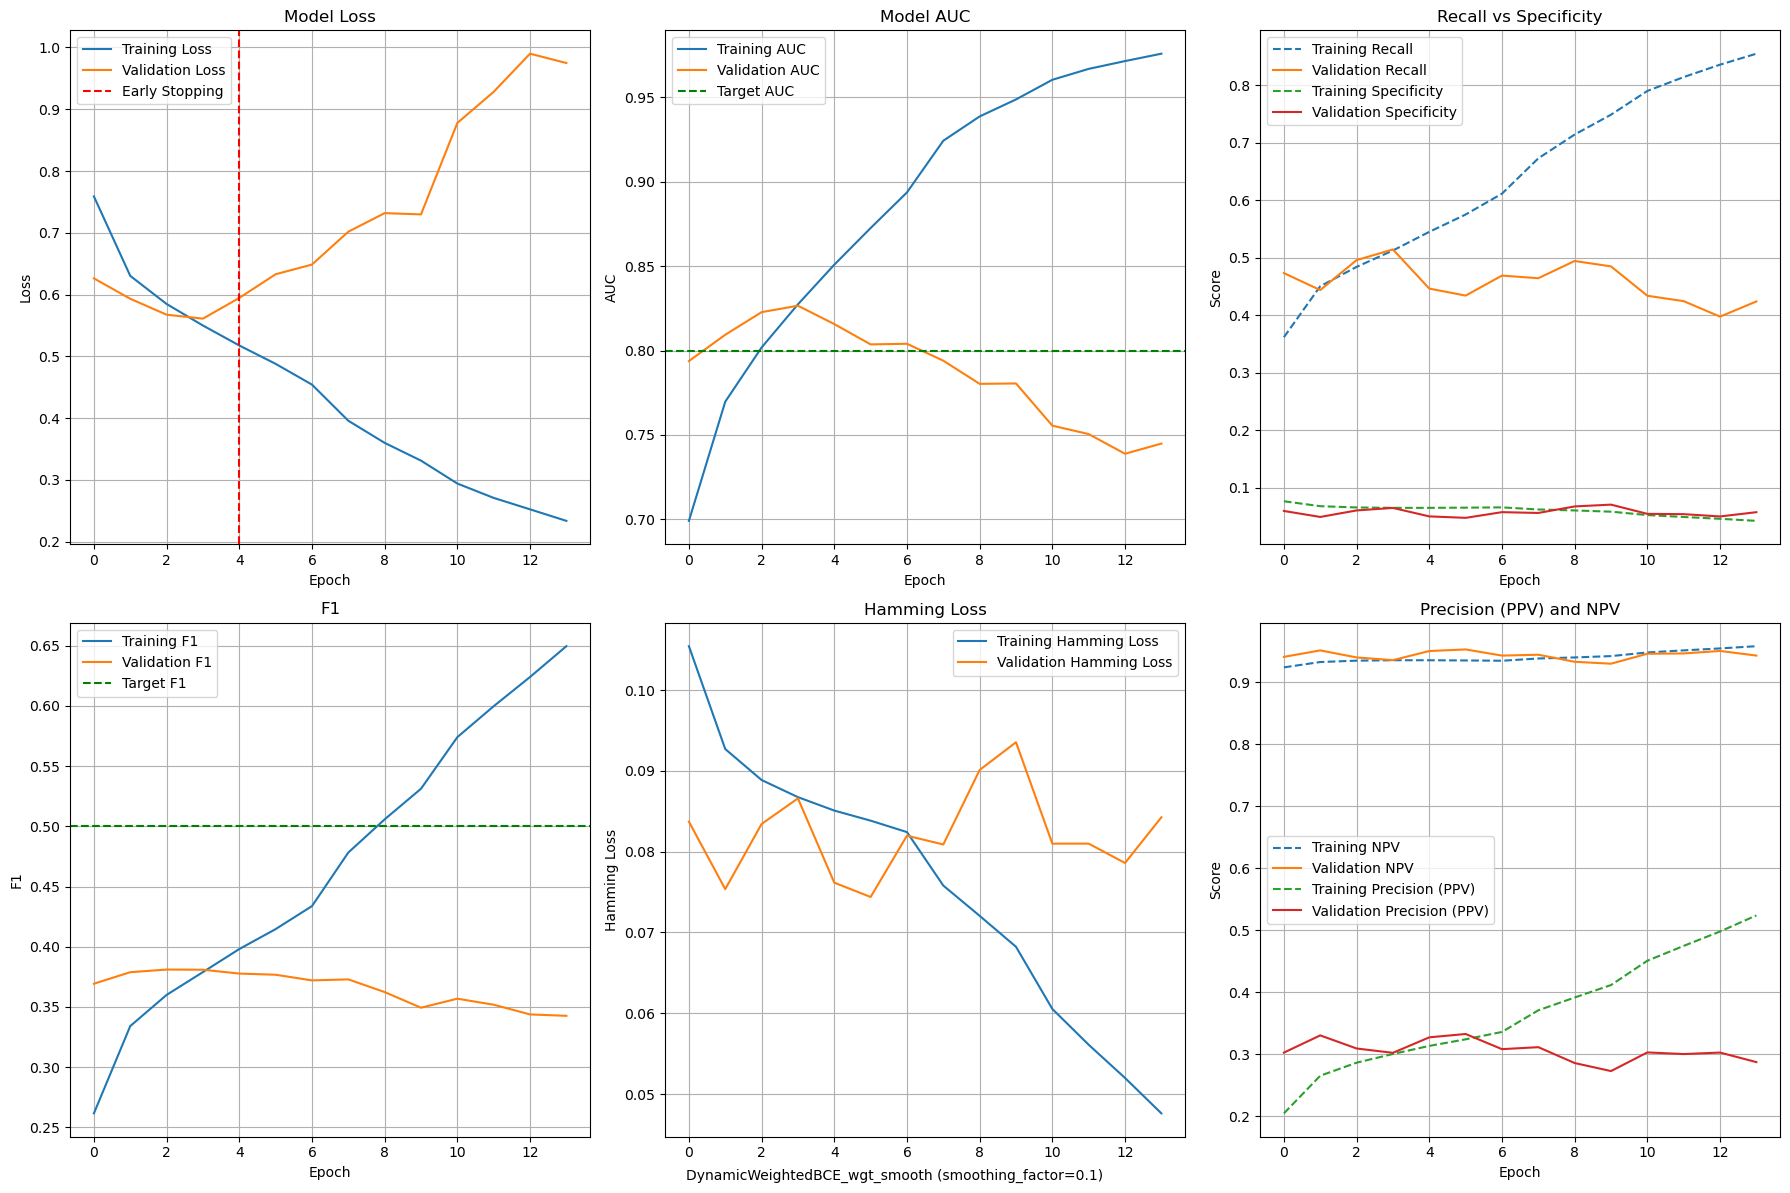

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_history(csv_file='model_statistics/training_history.csv'):
    # Read the CSV file
    history_df = pd.read_csv(csv_file)
    
    # Create figure with subplots in 2 rows
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    
    # First row - original plots
    # Plot loss
    ax1.plot(history_df['loss'], label='Training Loss')
    ax1.plot(history_df['val_loss'], label='Validation Loss')
    if early_stopping.monitor == "val_loss":
        ax1.axvline(x=early_stopping.best_epoch+1, color='r', linestyle='--', label='Early Stopping')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)
    
    # Plot AUC
    ax2.plot(history_df['auc'], label='Training AUC')
    ax2.plot(history_df['val_auc'], label='Validation AUC')
    ax2.axhline(y=0.80, color='g', linestyle='--', label='Target AUC')
    if early_stopping.monitor == "val_auc":
        ax2.axvline(x=early_stopping.best_epoch+1, color='r', linestyle='--', label='Early Stopping')
    ax2.set_title('Model AUC')
    ax2.set_ylabel('AUC')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    
    # Plot Recall vs Specificity
    ax3.plot(history_df['recall'], '--', label='Training Recall')
    ax3.plot(history_df['val_recall'], label='Validation Recall')
    ax3.plot(history_df['specificity'], '--', label='Training Specificity')
    ax3.plot(history_df['val_specificity'], label='Validation Specificity')
    ax3.set_title('Recall vs Specificity')
    ax3.set_ylabel('Score')
    ax3.set_xlabel('Epoch')
    ax3.legend()
    ax3.grid(True)
    
    # Second row - additional metrics
    # Plot f1
    ax4.plot(history_df['f1'], label='Training F1')
    ax4.plot(history_df['val_f1'], label='Validation F1')
    ax4.axhline(y=0.50, color='g', linestyle='--', label='Target F1')
    ax4.set_title('F1')
    ax4.set_ylabel('F1')
    ax4.set_xlabel('Epoch')
    ax4.legend()
    ax4.grid(True)
    
    # Plot Hamming Loss
    ax5.plot(history_df['hamming_loss'], label='Training Hamming Loss')
    ax5.plot(history_df['val_hamming_loss'], label='Validation Hamming Loss')
    ax5.set_title('Hamming Loss')
    ax5.set_ylabel('Hamming Loss')
    # ax5.set_xlabel('Epoch')
    ax5.legend()
    ax5.grid(True)
    
    # Plot Precision(PPV) and NPV
    ax6.plot(history_df['npv'], '--',label='Training NPV')
    ax6.plot(history_df['val_npv'], label='Validation NPV')
    ax6.plot(history_df['ppv'], '--', label='Training Precision (PPV)')
    ax6.plot(history_df['val_ppv'], label='Validation Precision (PPV)')
    ax6.set_title('Precision (PPV) and NPV')
    ax6.set_ylabel('Score')
    ax6.set_xlabel('Epoch')
    ax6.legend()
    ax6.grid(True)
    
    plt.tight_layout()
    
    # Add footnote
    plt.figtext(0.5, 0.01, f"{loss_fn_name}", ha='center', va='bottom')
    
    plt.savefig(f'model_statistics/plot_training_history_combined_{loss_fn_name}.png', dpi='figure', format='png')
    plt.show()
    plt.close()

plot_training_history()

## Evaluate Model Performance

In [16]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
import tensorflow as tf

def evaluate_model_performance(model, test_dataset, label_text):
    """
    Evaluate model performance with F1-optimized thresholds and comprehensive metrics
    
    Parameters:
    -----------
    model : tf.keras.Model
        Trained model
    test_dataset : tf.data.Dataset
        Test dataset with images and labels
    label_text : list
        List of class names
        
    Returns:
    --------
    metrics_per_class : dict
        Dictionary containing metrics for each class
    y_pred_probs : np.array
        Raw prediction probabilities
    y_true : np.array
        True labels
    y_pred_binary : np.array
        Binary predictions using optimal thresholds
    optimal_thresholds : np.array
        Optimal thresholds for each class
    """
    # Get predictions batch by batch
    all_predictions = []
    all_labels = []
    
    # Iterate through the dataset to get all predictions and labels
    for images, labels in test_dataset:
        pred_batch = model.predict(images, verbose=0)
        all_predictions.append(pred_batch)
        all_labels.append(labels.numpy())
    
    # Concatenate all batches
    y_pred_probs = np.concatenate(all_predictions, axis=0)
    y_true = np.concatenate(all_labels, axis=0)
    
    # Initialize arrays for binary predictions and metrics
    n_classes = len(label_text)
    optimal_thresholds = np.zeros(n_classes)
    y_pred_binary = np.zeros_like(y_pred_probs)
    metrics_per_class = {}
    
    # Calculate metrics per class
    for i, disease in enumerate(label_text):
        # Calculate precision-recall curve and find optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        
        # Calculate F1 scores and find optimal threshold
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
        optimal_idx = np.argmax(f1_scores[:-1])  # Exclude last point as it's a dummy point
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds[i] = optimal_threshold
        
        # Calculate binary predictions using optimal threshold
        y_pred_binary[:, i] = y_pred_probs[:, i] > optimal_threshold
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Calculate additional metrics
        best_precision = precision[optimal_idx]
        best_recall = recall[optimal_idx]
        best_f1 = f1_scores[optimal_idx]
        
        metrics_per_class[disease] = {
            'auc': roc_auc,
            'optimal_threshold': optimal_threshold,
            'precision': best_precision,
            'recall': best_recall,
            'f1_score': best_f1,
            'true_positive_rate': np.mean(y_true[:, i]),
            'predicted_positive_rate': np.mean(y_pred_binary[:, i]),
            'num_true_positives': np.sum(y_true[:, i]),
            'num_predicted_positives': np.sum(y_pred_binary[:, i])
        }
    
    # Print results in a readable format
    print("\nPer-class Performance Metrics (F1-optimized thresholds):")
    print("=" * 80)
    for disease, metrics in metrics_per_class.items():
        print(f"\n{disease}:")
        print(f"  AUC: {metrics['auc']:.3f}")
        print(f"  Optimal threshold: {metrics['optimal_threshold']:.3f}")
        print(f"  F1 Score: {metrics['f1_score']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall: {metrics['recall']:.3f}")
        print(f"  True positive rate: {metrics['true_positive_rate']:.3f}")
        print(f"  Predicted positive rate: {metrics['predicted_positive_rate']:.3f}")
        print(f"  Number of true positives: {metrics['num_true_positives']}")
        print(f"  Number of predicted positives: {metrics['num_predicted_positives']}")
    
    return metrics_per_class, y_pred_probs, y_true, y_pred_binary, optimal_thresholds

def apply_thresholds(y_pred_probs, thresholds):
    """
    Apply pre-computed thresholds to new prediction probabilities
    
    Parameters:
    -----------
    y_pred_probs : np.array
        Raw prediction probabilities from model, shape (n_samples, n_classes)
    thresholds : np.array
        Array of optimal thresholds for each class, shape (n_classes,)
        
    Returns:
    --------
    y_pred_binary : np.array
        Binary predictions using the provided thresholds
    """
    if y_pred_probs.shape[1] != len(thresholds):
        raise ValueError(f"Number of classes in predictions ({y_pred_probs.shape[1]}) "
                        f"doesn't match number of thresholds ({len(thresholds)})")
    
    y_pred_binary = np.zeros_like(y_pred_probs)
    for i in range(len(thresholds)):
        y_pred_binary[:, i] = y_pred_probs[:, i] > thresholds[i]
    
    return y_pred_binary

# Usage examples:
# 1. Full evaluation on test set:
metrics_dict, y_pred_probs, y_true, y_pred_binary, optimal_thresholds = evaluate_model_performance(
    model, test_dataset, label_text
)
#
# 2. Making predictions on new data:
# new_pred_probs = model.predict(new_images)
# new_pred_binary = apply_thresholds(new_pred_probs, optimal_thresholds)


Per-class Performance Metrics (F1-optimized thresholds):

Infiltration:
  AUC: 0.716
  Optimal threshold: 0.504
  F1 Score: 0.431
  Precision: 0.376
  Recall: 0.506
  True positive rate: 0.188
  Predicted positive rate: 0.252
  Number of true positives: 1042.0
  Number of predicted positives: 1401.0

Effusion:
  AUC: 0.889
  Optimal threshold: 0.536
  F1 Score: 0.552
  Precision: 0.471
  Recall: 0.667
  True positive rate: 0.121
  Predicted positive rate: 0.171
  Number of true positives: 673.0
  Number of predicted positives: 952.0

Atelectasis:
  AUC: 0.811
  Optimal threshold: 0.549
  F1 Score: 0.415
  Precision: 0.337
  Recall: 0.541
  True positive rate: 0.111
  Predicted positive rate: 0.179
  Number of true positives: 619.0
  Number of predicted positives: 993.0

Nodule:
  AUC: 0.771
  Optimal threshold: 0.531
  F1 Score: 0.328
  Precision: 0.306
  Recall: 0.352
  True positive rate: 0.054
  Predicted positive rate: 0.062
  Number of true positives: 298.0
  Number of predicted 

2025-01-01 21:20:03.086680: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Confusion Matrixes

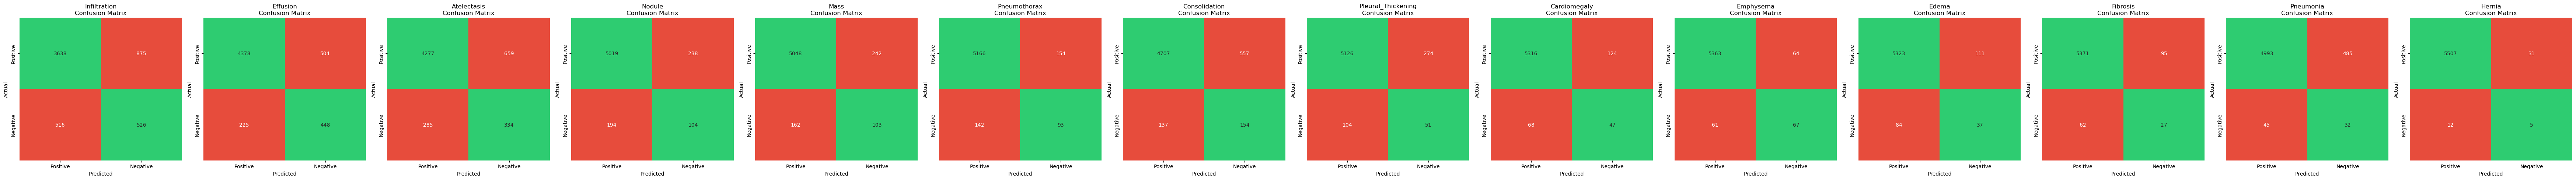

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Calculate confusion matrix for each label
conf_matrix = multilabel_confusion_matrix(y_true, y_pred_binary)

# Create subplots
num_labels = len(label_text)
fig, axes = plt.subplots(1, num_labels, figsize=(5*num_labels, 5))

# Create a custom colormap
colors = ['#e74c3c', '#2ecc71']  # [red, green]
custom_cmap = sns.color_palette(colors)

for i, (label, ax) in enumerate(zip(label_text, axes)):
    cm = conf_matrix[i]
    
    # Create a matrix for correct/incorrect predictions
    color_matrix = np.zeros_like(cm, dtype=float)
    np.fill_diagonal(color_matrix, 1)  # Set diagonal (TP, TN) to 1
    
    # Plot the confusion matrix without colorbar
    sns.heatmap(color_matrix,
                annot=cm,
                fmt='d',
                cmap=custom_cmap,
                xticklabels=['Positive', 'Negative'],
                yticklabels=['Positive', 'Negative'],
                ax=ax,
                cbar=False)  # This removes the colorbar
    
    ax.set_title(f'{label}\nConfusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()

plt.savefig('model_statistics/confusion_matrixes.png', dpi='figure', format='png')

plt.show()
plt.close()

## ROC Curves

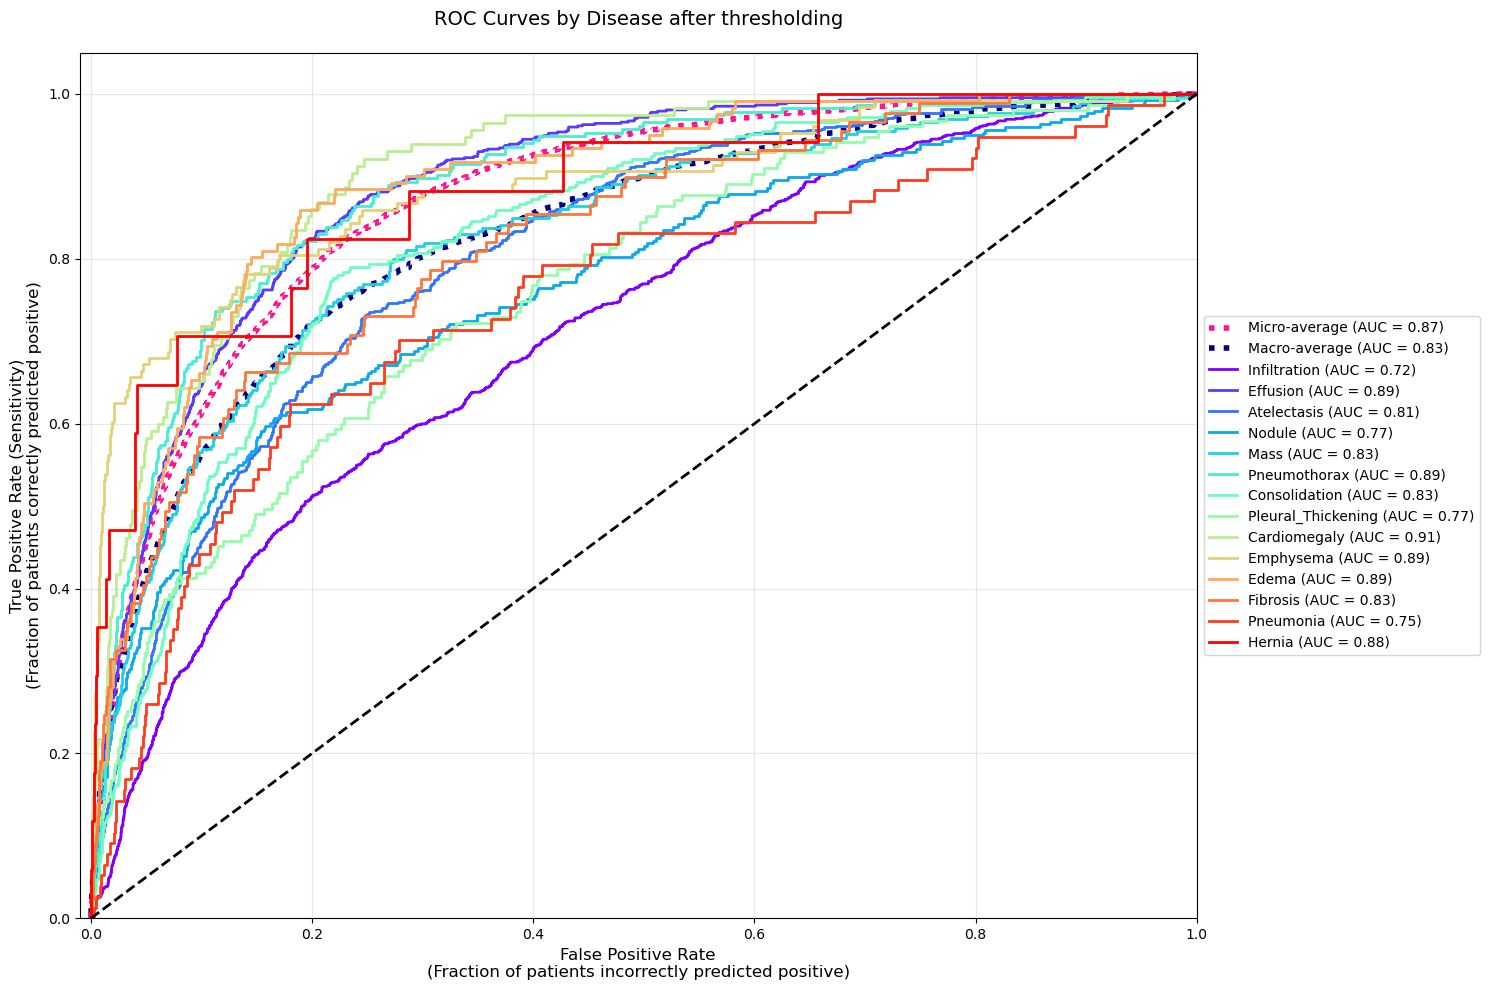

In [18]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_curves(y_true, y_pred_probs, label_text):
    """Plot ROC curves with disease names instead of class numbers"""
    n_classes = y_true.shape[1]
    
    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC curves for each disease
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Create figure ONCE
    fig = plt.figure(figsize=(15, 10))
    
    # Plot micro and macro average curves
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
            color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
            label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
            color='navy', linestyle=':', linewidth=4)
    
    # Plot ROC curves for each disease
    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{label_text[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Configure the plot
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate\n(Fraction of patients incorrectly predicted positive)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)\n(Fraction of patients correctly predicted positive)', fontsize=12)
    plt.title('ROC Curves by Disease', fontsize=14, pad=20)
    
    # Adjust legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('model_statistics/ROC_curves.png', dpi='figure', format='png')
    
    
    # Then show the plot
    plt.show()
    
    # Clear and close
    plt.close()

# Call with y_pred_probs instead of y_pred_binary
plot_roc_curves(y_true, y_pred_probs, label_text)  # Use probabilities, not binary predictions